In [127]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

1. функція, що генерує випадкову вибірку суміші нормальних розподілів

In [128]:
def GenerateNormalMix(Ms, Ds, p, size=500):
    if not (len(Ms) == len(Ds) == len(p)):
        raise ValueError("not (len(Ms) == len(Ds) == len(p).")

    K = len(p)
    x_vals = np.arange(K)

    control_samples = stats.rv_discrete(name='custm', values=(x_vals, p)).rvs(size=size)
    
    normal_samples = np.zeros((K, size))
    for i,(m,d) in enumerate(zip(Ms, Ds)):
        normal_samples[i] = stats.norm.rvs(loc=m, scale=d, size=size)

    result = normal_samples[ control_samples, range(size) ]

    return result

# Завдання 2

In [129]:
def EM_Task2(data, p_start, m_start, d_start, n_iter = 4):
    # known: distribution is a mix of 4 normal distributions
    # unknown:
    # - pk: (p1, p2, p3, p4)
    # - mk: (m1, m2, m3, m4)
    # - dk: (d1, d2, d3, d4)

    n = data.shape[0]

    # UTILITY FUNCTIONS

    # normal probability density function
    def pdf(yk, m, d):
        m = m.reshape(-1,1) # to make a column vector
        d = d.reshape(-1,1)
        return np.exp(-np.square(yk-m)/(2*d)) / np.sqrt(d) # / (np.sqrt(2*np.pi*d))
    
    # mixed probability density function
    # - p: [p1, p2, p3, p4]
    # - pdf: pdf[i,j] = p(y_j | phi_i)
    # result: 
    #   fk: fk[k] = f(y_k | theta)
    def f(p, pdf_ij):
        return p @ pdf_ij # це матричне множення

    # - p: [p1, p2, p3, p4]
    # - pdf: pdf[i,j] = p(y_j | phi_i)
    # - fk: fk[k] = f(y_k | theta)
    # result: 
    #   wij: wij[i,j] = w_i(y_j | theta)
    def w(p, pdf_ij, fk):
        return p.reshape(-1,1) * pdf_ij / fk # w_ij = p_i * p(y_j | phi_i) / f(y_j | theta)

    # calculate new p_i
    # - wij: wij[i,j] = w_i(y_j | theta)
    # result:
    #   p : p[i] = p_i
    def calculate_p(wij):
        return wij.mean(axis=1) # p_i = sum_j w_ij / n

    # calculate new m_i
    # - wij: wij[i,j] = w_i(y_j | theta)
    # result:
    #   m : m[i] = m_i
    def calculate_m(yk, wij):
        new_m = (yk * wij).sum(axis=1) / wij.sum(axis=1) # m_i = sum_k y_k w_ik / sum_j w_ij
        return new_m

    # calculate new d_i (variance)
    # - wij: wij[i,j] = w_i(y_j | theta)
    # result:
    #   d : d[i] = d_i
    def calculate_d(new_m, yk, wij):
        new_m = new_m.reshape(-1,1) # to make a column vector
        new_d = (np.square(yk - new_m) * wij).sum(axis=1) / wij.sum(axis=1) # d_i = sum_k ((y_k - m_i)^2 w_ik) / sum_j w_ij
        return new_d

    # BEGIN ALGORITHM

    p = p_start
    m = m_start
    d = d_start

    history = dict(p=[p], m=[m], d=[d])
    for step in range(n_iter):
        pdf_ij = pdf(data, m, d)
        # print('pdf_ij : \n', pdf_ij)
        fk = f(p, pdf_ij)

        # prevent 0/0 division while calculating w_ij
        outliers = (fk < 1e-12) # indices of points with dangerously low probability
        fk[outliers] = 1
        pdf_ij[:, outliers] = 0

        # print('fk : \n', fk)
        wij = w(p, pdf_ij, fk)
        # print('wij : \n', wij)
        
        p_new = calculate_p(wij)
        # print('p_new : ', p_new)
        m_new = calculate_m(data, wij)
        # print('m_new : ', m_new)
        d_new = calculate_d(m_new, data, wij)
        # print('d_new : ', d_new)

        # break

        p, m, d = p_new, m_new, d_new
        history['p'].append(p)
        history['m'].append(m)
        history['d'].append(d)
    
    return (p, m, d), history
    

## Генерація вибірки


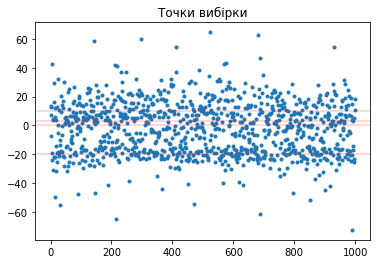

In [130]:
# генеруємо вибірку та дивимося на неї
data = GenerateNormalMix([-20, 0, 3, 10], [4, 25, 16, 9], [1/4, 1/4, 1/4, 1/4], 1000)
plt.plot(data, '.')
plt.title('Точки вибірки')
plt.axhline(-20, alpha=0.2, c='r')
plt.axhline(0, alpha=0.2, c='r')
plt.axhline(3, alpha=0.2, c='r')
plt.axhline(10, alpha=0.2, c='r')

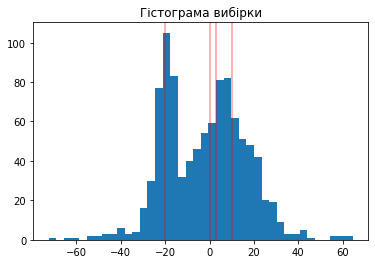

In [131]:
plt.hist(data, 40)
plt.title('Гістограма вибірки')
plt.axvline(-20, alpha=0.4, c='r')
plt.axvline(0, alpha=0.4, c='r')
plt.axvline(3, alpha=0.4, c='r')
plt.axvline(10, alpha=0.4, c='r')

## Тестування
Тут одразу виникли проблеми. Деякі точки згенерувались так далеко, що в обчисленнях виникло ділення на 0. 
Тому знадобилось додати перевірку на занадто малоймовірні точки та викидати їх з обчислень. З цією ж ціллю я викинув фактор $\frac{1}{\sqrt{2\pi}}$ в обчисленнях, бо він все одно має скоротитися 

In [132]:
p_true = np.array([1/4, 1/4, 1/4, 1/4])
m_true = np.array([-20, 0, 3, 10])
d_true = np.array([4, 25, 16, 9])

# запускаємо спочатку на правильному значенні p та правильних значеннях m.
# перевіряємо, як алгоритм обчислить дисперсії

d0 = np.array([1,1,1,1])
res, history = EM_Task2(data, p_true, m_true, d0, n_iter=4)
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

p*: [0.40042802 0.12618136 0.10460239 0.36878822]
m*: [-20.44936847  -3.4434135    4.68426357  16.00810295]
d*: [ 77.27203635  14.78930085   4.62908678 115.01149373]


In [133]:
res, history = EM_Task2(data, p_true, m_true, d0, n_iter=16)
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

p*: [0.45591145 0.04091447 0.09542729 0.40774678]
m*: [-17.94784352  -0.60058038   6.28287243  13.19012898]
d*: [111.40710884  12.66150878   8.59735081 166.13629103]


In [134]:
res, history = EM_Task2(data, p_true, m_true, d0, n_iter=32)
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

p*: [0.46171587 0.02375915 0.0968359  0.41768908]
m*: [-17.4253523    1.04411898   6.86942535  12.27261587]
d*: [120.53262209   9.17233536  12.08535535 183.6537681 ]


Щось не дуже. Але неозброєним оком також не видно всі 4 розподіли.

Тепер спробуємо взяти іншу початкову точку

In [135]:
p0 = p_true
m0 = np.array([-20, 0, 0.1, 10])
d0 = np.array([4, 4, 4, 4])

res, history = EM_Task2(data, p0, m0, d0, n_iter=32)
print("Початкова точка: ", list(zip(m0,d0)))
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

Початкова точка:  [(-20.0, 4), (0.0, 4), (0.1, 4), (10.0, 4)]
p*: [0.46212706 0.10940247 0.11134979 0.31712067]
m*: [-17.17104821   9.91179666   7.3416026   11.99523009]
d*: [123.72690047  50.74425084  33.97923987 240.62212308]


In [136]:
p0 = p_true
m0 = np.array([-20, 0, 1, 10])
d0 = np.array([4, 4, 4, 4])

res, history = EM_Task2(data, p0, m0, d0, n_iter=32)
print("Початкова точка: ", list(zip(m0,d0)))
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

Початкова точка:  [(-20, 4), (0, 4), (1, 4), (10, 4)]
p*: [0.45859644 0.06040128 0.12868847 0.3523138 ]
m*: [-17.3930072    9.75481773   6.8810379   12.12625683]
d*: [121.31253635  78.22140829  23.65210386 214.78407969]


In [137]:
p0 = p_true
m0 = np.array([-20, 0, 1, 10])
d0 = d_true

res, history = EM_Task2(data, p0, m0, d0, n_iter=32)
print("Початкова точка: ", list(zip(m0,d0)))
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

Початкова точка:  [(-20, 4), (0, 25), (1, 16), (10, 9)]
p*: [0.26779061 0.27192162 0.20649689 0.25379088]
m*: [-19.72501723  -1.82559796   0.90987724  13.24435918]
d*: [ 15.59541546 581.05893491  55.47952172  71.05063937]


In [138]:
p0 = p_true
m0 = np.array([-25, -1, 2, 6])
d0 = d_true

res, history = EM_Task2(data, p0, m0, d0, n_iter=32)
print("Початкова точка: ", list(zip(m0,d0)))
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

Початкова точка:  [(-25, 4), (-1, 25), (2, 16), (6, 9)]
p*: [0.23862557 0.37421671 0.20374387 0.18341384]
m*: [-19.82363403  -1.17950392   5.2166042   10.24761976]
d*: [ 13.14681412 489.40759084 102.71957597  82.56262492]


Стійкість:

In [139]:
p0 = p_true
m0 = m_true
d0 = d_true

res, history = EM_Task2(data, p0, m0, d0, n_iter=1000)
print("Початкова точка: ", list(zip(m0,d0)))
print('p*:', res[0])
print('m*:', res[1])
print('d*:', res[2])

Початкова точка:  [(-20, 4), (0, 25), (3, 16), (10, 9)]
p*: [0.27391032 0.22234747 0.34369183 0.16005037]
m*: [-19.80731271  -2.36553435   3.20964974  16.36271146]
d*: [ 16.13391825 650.49468198  78.67882437  64.08976356]


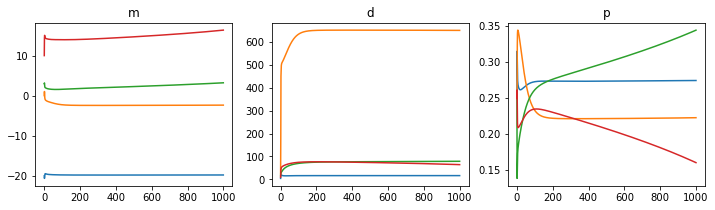

In [140]:
fig, axs = plt.subplots(1,3)
axs[0].plot(history['m'])
axs[0].set_title('m')
axs[1].plot(history['d'])
axs[1].set_title('d')
axs[2].plot(history['p'])
axs[2].set_title('p')
fig.set_size_inches((12,3))

Випробував різні початкові точки. найцікавіші спостереження наступні:
- на цих вхідних даних алгоритм працює погано
- алгоритм "бачить" лише $\mathcal N(-20, 4)$ та $\mathcal N(10,9)$ - так як і людина неозброєним оком
- розподіли біля нуля зливаються в один
- алгоритм схильний відправляти багато точок, що не вписуються в модель, в розподіл з матсподіванням 0, великою дисперсією та великим значенням змішуючої ймовірності 
- алгоритм нестійкий: якщо подати на вхід еталонні значення, то він з часом відходитиме від них
    - звідси випливає, що іноді збільшення кількості ітерацій не допомагає, а навіть шкодить
- алгоритм дуже залежить від вхідних даних: поведінка та графіки еволюції оцінок якісно відрізняються